# FMRI Classifier

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from src.dataset.kay import load_dataset
from src.utils.util import prepare_fmri_data

from src.ml.test import test_model
from src.ml.train import train_model
from src.ml.model import FMRIClassifier
from src.ml.config import FMRIClassifierConfig
from src.ml.dataset import FMRIDataset, create_weighted_sampler
from src.ml.utils import plot_loss_acc_curves, generate_score_report

In [2]:
%matplotlib inline

sns.set(style="ticks", context="talk")
plt.style.use("dark_background")

title_size = 16
params = {
    "legend.fontsize": 14,
    "axes.labelsize": title_size - 2,
    "axes.titlesize": title_size,
    "xtick.labelsize": title_size - 4,
    "ytick.labelsize": title_size - 4,
    "axes.titlepad": 1.5 * title_size,
}

plt.rcParams.update(params)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)

We're using => cuda


In [4]:
config = FMRIClassifierConfig()

## Load Data

In [5]:
all_data = load_dataset(data_path="./../data/")

In [6]:
x_train, y_train = prepare_fmri_data(
    all_data=all_data,
    data_subset="train",
    class_ignore_list=config.class_ignore_list,
    label_level=config.label_level,
    roi_select_list=config.roi_select_list,
)


x_test, y_test = prepare_fmri_data(
    all_data=all_data,
    data_subset="test",
    class_ignore_list=config.class_ignore_list,
    label_level=config.label_level,
    roi_select_list=config.roi_select_list,
)

In [7]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1593, 8427), (1593,), (114, 8427), (114,))

In [8]:
class2idx = {k: i for i, k in enumerate(np.unique(y_train))}
idx2class = {v: k for k, v in class2idx.items()}

## Create Dataset and Dataloader

In [9]:
train_dataset = FMRIDataset(x_data=x_train, y_data=y_train, class2idx=class2idx)
test_dataset = FMRIDataset(x_data=x_test, y_data=y_test, class2idx=class2idx)


weighted_sampler = create_weighted_sampler(y_train, class2idx)


train_loader = DataLoader(
    dataset=train_dataset,
    shuffle=False,
    batch_size=config.batch_size,
    sampler=weighted_sampler,
)

test_loader = DataLoader(
    dataset=test_dataset, shuffle=False, batch_size=config.batch_size
)

## Initialize Model

In [10]:
model = FMRIClassifier(num_features=x_train.shape[1], num_classes=len(class2idx))
model.to(device)

epochs = config.epochs
criterion = nn.CrossEntropyLoss()  # weight=class_weights.to(device)
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

## Train Model

In [11]:
loss_stats, acc_stats = train_model(
    model=model,
    epochs=epochs,
    train_loader=train_loader,
    val_loader=test_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    save_model_path="./../models/fmri_classifier/fmri_classifier_model.pth",
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 01/10: | Train Loss: 1.13998 | Val Loss: 1.07947 | Train Acc: 38.538% | Val Acc: 39.000%
Epoch 02/10: | Train Loss: 1.01916 | Val Loss: 1.04581 | Train Acc: 46.308% | Val Acc: 44.000%
Epoch 03/10: | Train Loss: 0.83889 | Val Loss: 0.90145 | Train Acc: 60.231% | Val Acc: 52.000%
Epoch 04/10: | Train Loss: 0.69021 | Val Loss: 0.95426 | Train Acc: 69.308% | Val Acc: 46.000%
Epoch 05/10: | Train Loss: 0.59045 | Val Loss: 0.88416 | Train Acc: 74.385% | Val Acc: 54.000%
Epoch 06/10: | Train Loss: 0.47557 | Val Loss: 0.89490 | Train Acc: 79.077% | Val Acc: 56.000%
Epoch 07/10: | Train Loss: 0.38193 | Val Loss: 0.95501 | Train Acc: 83.923% | Val Acc: 58.000%
Epoch 08/10: | Train Loss: 0.31833 | Val Loss: 1.45161 | Train Acc: 86.692% | Val Acc: 51.000%
Epoch 09/10: | Train Loss: 0.28726 | Val Loss: 1.26797 | Train Acc: 89.462% | Val Acc: 58.000%
Epoch 10/10: | Train Loss: 0.24503 | Val Loss: 1.23919 | Train Acc: 90.923% | Val Acc: 52.000%


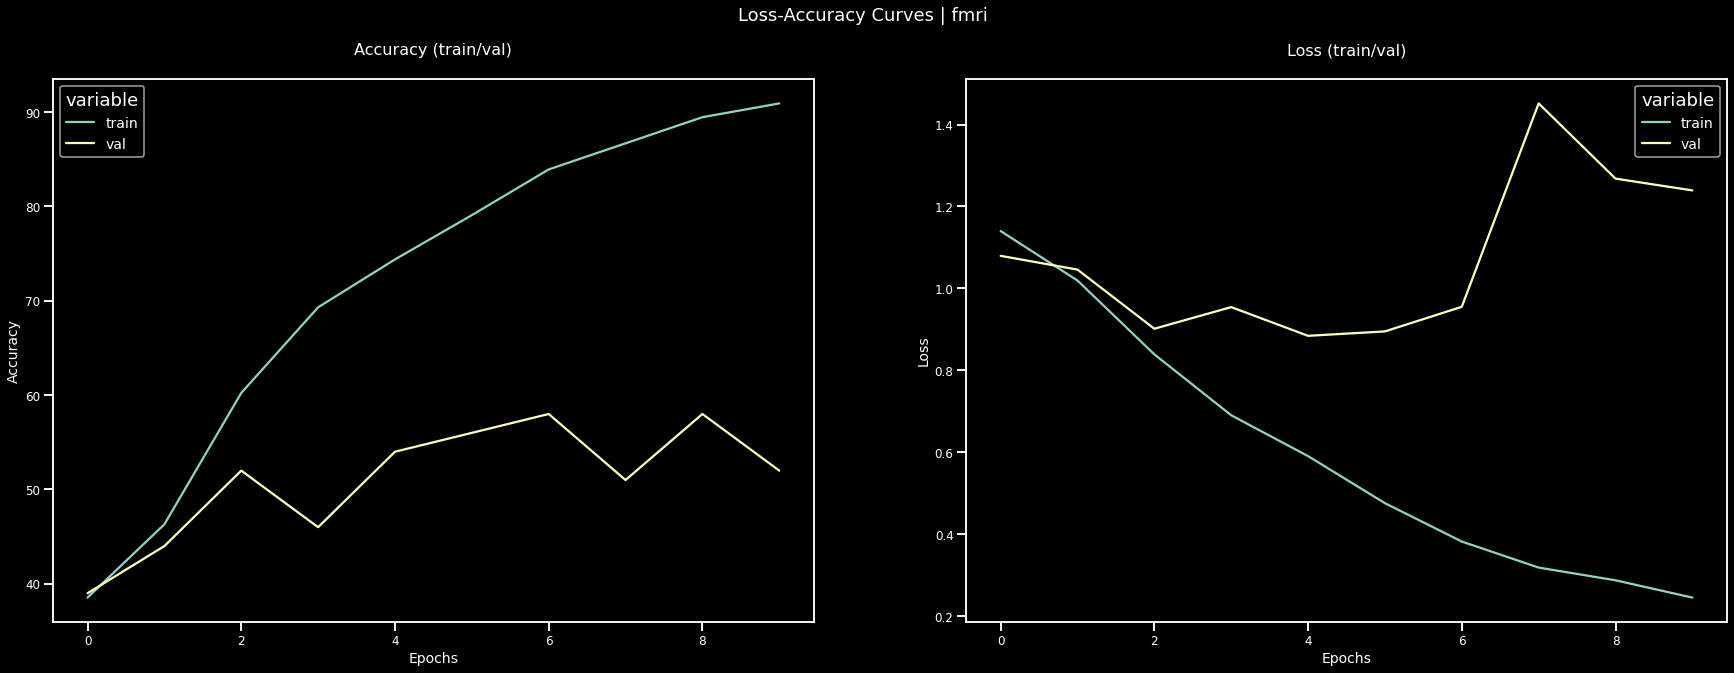

In [12]:
plot_loss_acc_curves(loss_stats, acc_stats, model_name="fmri")

## Test Model

In [13]:
y_true_list, y_pred_list = test_model(model, test_loader, device)

  0%|          | 0/1 [00:00<?, ?it/s]

Classification Report | fmri:

              precision    recall  f1-score   support

           0       0.67      0.30      0.41        54
           1       0.47      0.82      0.60        50
           2       0.67      0.20      0.31        10

    accuracy                           0.52       114
   macro avg       0.60      0.44      0.44       114
weighted avg       0.58      0.52      0.48       114






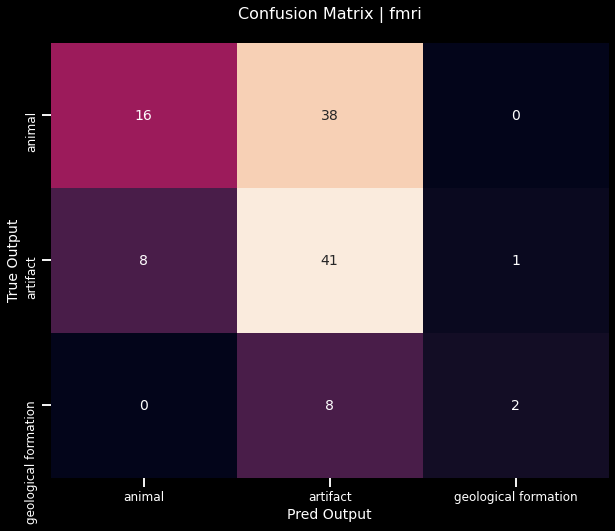

In [14]:
generate_score_report(
    y_true=y_true_list, y_pred=y_pred_list, idx2class=idx2class, model_name="fmri"
)